In [ ]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv, read_feather
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time
import emcee
import corner


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [2]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        # fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        
        fluxes = self._blackbody_flux(temperature, radius, wvs / (1 + redshift)) # this is a luminosity density

        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3
        fluxes[t < 0,:] = 0.* u.kg *u.m / u.s**3


        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density / (1 + redshift)


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [3]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)

bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

# zeropoints from https://smtn-002.lsst.io/
zeropoints = [28.51, 28.36, 28.17, 27.78]
# LSST sky brightness in mag/arcsec^2 (from SMTN-002 official values)
sky_brightness_mag = [22.25, 21.2, 20.46, 19.61]  # g, r, i, z bands

# LSST observing parameters (from official LSST specs)
exptime = 30.0  # seconds per visit (2x15s exposures)
pixel_scale = 0.2  # arcseconds per pixel (LSST camera)
aperture_radius = 1.0  # arcseconds (typical PSF aperture, will be calculated properly)
read_noise = 8.8  # electrons per pixel per exposure
dark_current = 0.2  # electrons per pixel per second
num_bands = len(bands)

# Convert sky brightness to sky noise (electrons/pixel/second)
# Using LSST effective area = 6.423m diameter, pixel scale = 0.2 arcsec/pixel
# Sky noise = sky_flux * effective_area * pixel_area / exposure_time
# For now, using approximate values - these should be calculated more precisely
sky_noise = 10**(-0.4*(np.asarray(sky_brightness_mag) - np.asarray(zeropoints))) * pixel_scale**2  # g, r, i, z bands (electrons/pixel/second)


ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})

ibc_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':np.repeat(sky_noise, num_points),
             'exptime': exptime * np.ones(num_points*num_bands),
             'pixel_scale': pixel_scale * np.ones(num_points*num_bands),
             'aperture_radius': aperture_radius * np.ones(num_points*num_bands),
             'read_noise': read_noise * np.ones(num_points*num_bands),
             'dark_current': dark_current * np.ones(num_points*num_bands)})



In [4]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(-5,  30), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [5]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [6]:
def fit_ia(true_z, lcs):    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

100%|██████████| 1000/1000 [00:18<00:00, 53.23it/s]
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


(32000, 5)


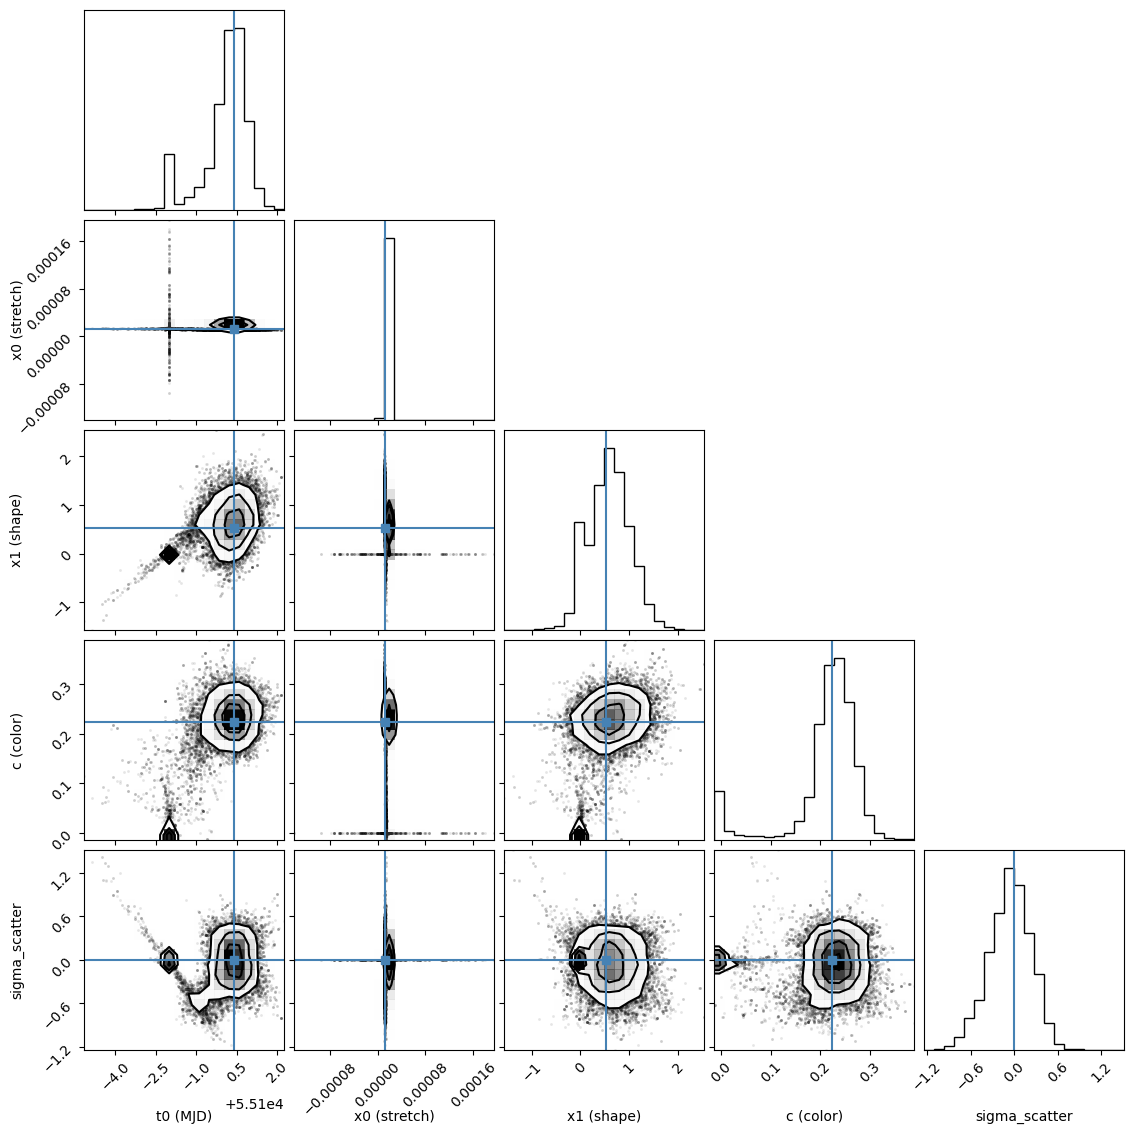

In [ ]:
model = sncosmo.Model(source='salt2')
data = sncosmo.load_example_data()

def log_likelihood(parameters):
    # parameters: [t0, x0, x1, c, sigma_scatter]
    model.set(z=0.5, t0=parameters[0], x0=parameters[1], x1=parameters[2], c=parameters[3])
    sigma_scatter = parameters[4]
    model_flux = model.bandflux(data['band'], data['time'],
                                zp=data['zp'], zpsys=data['zpsys'])
    resid = (data['flux'] - model_flux)
    sigma2 = data['fluxerr'] ** 2
    sigma_tot = sigma2 + sigma_scatter**2
    return -0.5 * np.sum(resid ** 2 / sigma_tot + np.log(2 * np.pi * sigma_tot))

ndim = 5  # t0, x0, x1, c, sigma_scatter
nwalkers = 32
start_parameters = [55098., 1e-5, 0., 0., 0.]
pos = start_parameters + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
sampler.run_mcmc(pos, 1000, progress=True)

samples = sampler.get_chain(flat=True)
print(samples.shape)

# compare to SNCosmo fitting
ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
this_ia_model = sncosmo.Model(source=ia_source)

this_ia_model.set(z = 0.5)

result, fitted_model = sncosmo.fit_lc(data, this_ia_model,
['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})

fig = corner.corner(samples, labels=["t0 (MJD)", "x0 (stretch)", "x1 (shape)", "c (color)", "sigma_scatter"], truths=list(result.parameters[1:])+[0.])

In [71]:
def ia_log_likelihood(parameters, model, true_z, data):
    # parameters: [t0, x0, x1, c, sigma_scatter]
    model.set(z=true_z, t0=parameters[0], x0=parameters[1], x1=parameters[2], c=parameters[3])
    sigma_scatter = parameters[4]
    model_flux = model.bandflux(data['band'], data['time'],
                                zp=data['zp'], zpsys=data['zpsys'])
    resid = (data['flux'] - model_flux)
    sigma2 = data['fluxerr'] ** 2
    sigma_tot = sigma2 + sigma_scatter**2
    return -0.5 * np.sum(resid ** 2 / sigma_tot + np.log(2 * np.pi * sigma_tot))


def fit_ia_mcmc(true_z, lcs, start_parameters = [55098., 1e-5, 0., 0., 0.]):    
    ia_source = sncosmo.get_source('salt2-extended', version='2.0')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    ndim = 5  # t0, x0, x1, c, sigma_scatter
    nwalkers = 32
    # start_parameters = [55098., 1e-5, 0., 0., 0.]
    pos = start_parameters + 1e-4 * np.random.randn(nwalkers, ndim)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, ia_log_likelihood, args=(this_ia_model, true_z, lcs[0],))
    sampler.run_mcmc(pos, 1000, progress=True)

    samples = sampler.get_chain(flat=True)
    
    return samples

<ErrorbarContainer object of 3 artists>

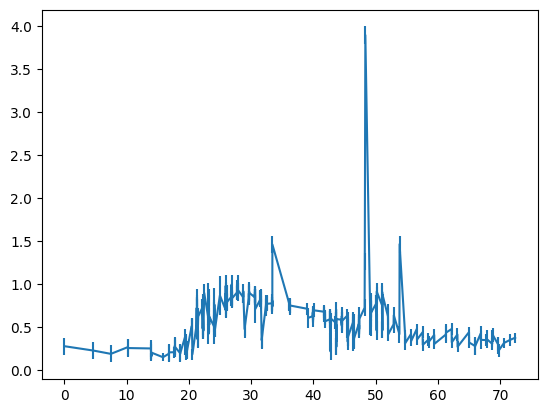

In [78]:
from astropy.table import Table
import pyarrow.feather as feather

# Read the feather file as a pyarrow Table
# Read the feather file as a pyarrow Table and convert to astropy Table
lc_table = feather.read_table("_ts.feather")

# print(lc_table.schema)

def ns_to_days(ns):
    return ns / (1e9 * 60 * 60 * 24)

def read_feather_file(filename):

    lc_table = feather.read_table(filename)


    # Convert each column to a numpy array and print its name and shape
    columns = {}
    for col_name in ['phase', 'mag', 'mag_error', 'flux', 'flux_error', 'filter', 'zeropoint']:
        arr = np.array(lc_table[col_name])
        # print(f"{col_name}: shape {arr.shape}")
        # Replace NaNs with zero if the dtype is float
        if np.issubdtype(arr.dtype, np.floating):
            arr = np.nan_to_num(arr, nan=0.1)
        columns[col_name] = arr

    columns['time'] = columns['phase'] - np.min(columns['phase'])
    columns['zp'] = columns['zeropoint']
    columns['fluxerr'] = columns['flux_error']


    # columns['time'] = columns['phase']

    columns['zpsys'] = np.array(['ab'] * len(columns['phase']), dtype=str)

    band_name_dict = {'ZTF_r': 'ztfr', 'ZTF_g': 'ztfg', 'ZTF_i': 'ztfi'}

    columns['band'] = np.array([band_name_dict[i] for i in columns['filter']], dtype=str)

    # remove unit from time and convert to days, then to float64
    # If the dtype is timedelta64[ns], convert to float days
    if np.issubdtype(columns['time'].dtype, np.timedelta64):
        columns['time'] = columns['time'].astype('timedelta64[ns]').astype('float64') / (1e9 * 60 * 60 * 24)
    columns['time'] = columns['time'].astype(np.float64)

    # Remove the 'phase' column
    del columns['phase']
    del columns['filter']
    del columns['flux_error']
    del columns['zeropoint']


    # Create an astropy Table from these columns
    astropy_lc_table = Table(columns)
    # print(astropy_lc_table)
    return astropy_lc_table

astropy_lc_table = read_feather_file("_ts.feather")

plt.errorbar(astropy_lc_table['time'], astropy_lc_table['flux'], yerr = astropy_lc_table['fluxerr'])


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


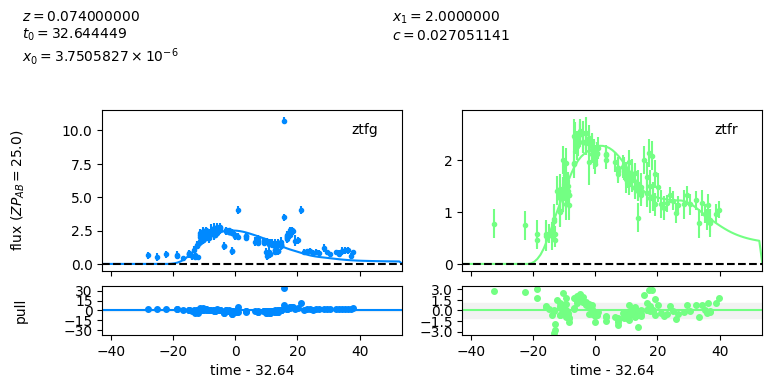

In [60]:
result, fitted_model = fit_ia(0.074, [astropy_lc_table])
sncosmo.plot_lc(astropy_lc_table, model=fitted_model);

100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s]


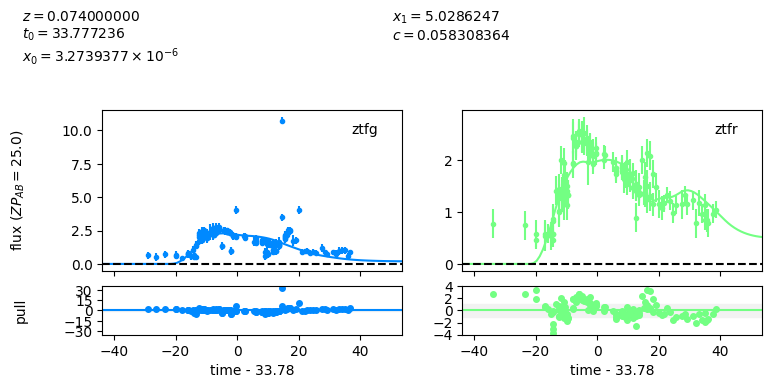

In [79]:
param_samples = fit_ia_mcmc(0.074, [astropy_lc_table], start_parameters = [32, 1e-5, 0., 0., 0.])

# Compute the mean of the parameter samples
mean_params = np.mean(param_samples, axis=0)[:4]  # [t0, x0, x1, c], ignore sigma_scatter

# Create a model with the mean parameters
model.set(z=0.074, t0=mean_params[0], x0=mean_params[1], x1=mean_params[2], c=mean_params[3])

# Plot the observed light curve and the fit
sncosmo.plot_lc(astropy_lc_table, model=model)
plt.show()


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


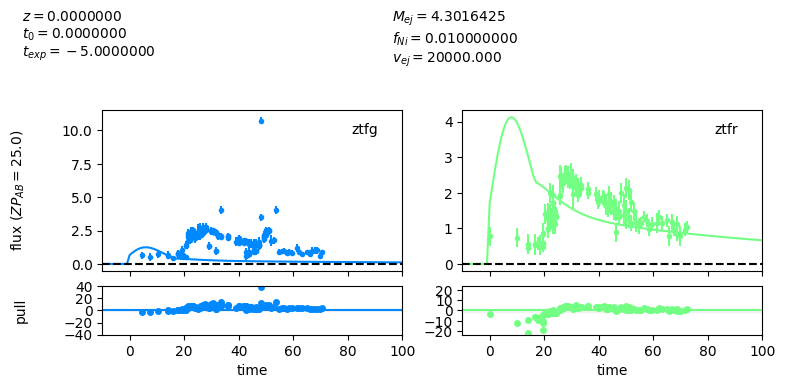

In [80]:
result, fitted_model = fit_ibc(0.074, [astropy_lc_table])
sncosmo.plot_lc(astropy_lc_table, model=fitted_model);

In [91]:
def ibc_log_likelihood(parameters, model, true_z, data):
    # parameters: [texp, mej, fni, vej, sigma_scatter]
    print(parameters)
    model.set(z=true_z, texp=parameters[0], mej=parameters[1], fni=parameters[2], vej=parameters[3])
    sigma_scatter = parameters[4]
    model_flux = model.bandflux(data['band'], data['time'],
                                zp=data['zp'], zpsys=data['zpsys'])
    resid = (data['flux'] - model_flux)
    sigma2 = data['fluxerr'] ** 2
    sigma_tot = sigma2 + sigma_scatter**2
    return -0.5 * np.sum(resid ** 2 / sigma_tot + np.log(2 * np.pi * sigma_tot))

def fit_ibc_mcmc(true_z, lcs, start_parameters = [5, 3, 0.05, 15000, 1.]):
    # Use your ArnettSource and sncosmo.Model setup
    arnett_source = ArnettSource(times, wavelengths, true_z, params=start_parameters[:4])
    arnett_model = sncosmo.Model(source=arnett_source)
    
    ndim = 5  # texp, mej, fni, vej, sigma_scatter
    nwalkers = 32
    pos = np.array(start_parameters) + 1e-4 * np.random.randn(nwalkers, ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ibc_log_likelihood, args=(arnett_model, true_z, lcs[0],))
    sampler.run_mcmc(pos, 1000, progress=True)
    
    samples = sampler.get_chain(flat=True)
    return arnett_model, samples

In [94]:
model, param_samples = fit_ibc_mcmc(0.074, [astropy_lc_table], start_parameters = [-5, 5, 0.05, 15000, 2.])

# Compute the mean of the parameter samples
mean_params = np.mean(param_samples, axis=0)[:4]  # [t0, x0, x1, c], ignore sigma_scatter

# Create a model with the mean parameters
model.set(z=0.074, texp=mean_params[0],mej=mean_params[1], fni=mean_params[2], vej=mean_params[3])

# Plot the observed light curve and the fit
sncosmo.plot_lc(astropy_lc_table, model=model)
plt.show()

[-5.00004625e+00  4.99998752e+00  4.99706498e-02  1.49999999e+04
  1.99998672e+00]
[-4.99993781e+00  5.00003613e+00  4.99139840e-02  1.50000001e+04
  1.99998197e+00]
[-5.00000939e+00  4.99990132e+00  5.02900825e-02  1.50000000e+04
  1.99994535e+00]
[-4.99997103e+00  4.99994851e+00  5.01367328e-02  1.50000003e+04
  2.00012635e+00]
[-4.99998733e+00  4.99998729e+00  4.99115593e-02  1.49999999e+04
  1.99988985e+00]
[-4.99989893e+00  5.00001404e+00  5.00526110e-02  1.50000000e+04
  2.00006188e+00]
[-5.00001059e+00  5.00003848e+00  5.01653427e-02  1.49999999e+04
  2.00008424e+00]
[-5.00001497e+00  4.99998329e+00  5.00109539e-02  1.50000000e+04
  1.99997735e+00]
[-4.99992899e+00  5.00002741e+00  5.00120305e-02  1.49999999e+04
  1.99990133e+00]
[-4.99997120e+00  4.99994355e+00  5.02144149e-02  1.49999999e+04
  1.99997978e+00]
[-4.99991774e+00  4.99986507e+00  5.00716588e-02  1.49999999e+04
  2.00025745e+00]
[-5.00021653e+00  4.99999018e+00  4.99969907e-02  1.49999999e+04
  2.00005699e+00]
[-5.

  0%|          | 0/1000 [00:00<?, ?it/s]

[-4.99993145e+00  5.00003937e+00  4.99143981e-02  1.50000001e+04
  1.99998565e+00]
[-4.99995595e+00  4.99997682e+00  5.00919961e-02  1.50000001e+04
  2.00004563e+00]
[-4.99990569e+00  5.00006669e+00  5.00126625e-02  1.50000000e+04
  2.00002860e+00]
[-5.00000161e+00  5.00001641e+00  5.01371344e-02  1.49999999e+04
  2.00007537e+00]
[-5.00004551e+00  4.99997043e+00  4.99885318e-02  1.50000001e+04
  1.99995165e+00]
[-4.99994081e+00  4.99997379e+00  5.01649059e-02  1.50000000e+04
  2.00006581e+00]
[-5.00002956e+00  4.99981671e+00  4.98445876e-02  1.49999999e+04
  1.99995330e+00]
[-4.99994740e+00  4.99993480e+00  4.98466788e-02  1.50000000e+04
  1.99995389e+00]
[-4.99993260e+00  4.99996584e+00  5.03096732e-02  1.49999998e+04
  2.00011386e+00]
[-5.00013863e+00  4.99999389e+00  5.00896963e-02  1.50000000e+04
  1.99997023e+00]
[-4.99997408e+00  5.00010327e+00  4.98824259e-02  1.50000000e+04
  1.99991608e+00]
[-4.99977470e+00  4.99996951e+00  5.00420500e-02  1.49999999e+04
  1.99973124e+00]
[-4.

  0%|          | 1/1000 [00:02<43:14,  2.60s/it]

[-5.00017694e+00  4.99989429e+00  4.98357703e-02  1.50000001e+04
  1.99980886e+00]
[-5.00022009e+00  5.00027925e+00  4.98962743e-02  1.50000001e+04
  2.00032568e+00]
[-4.99995377e+00  4.99996414e+00  4.98774917e-02  1.50000000e+04
  1.99992579e+00]
[-4.99990136e+00  5.00007442e+00  5.00058409e-02  1.50000000e+04
  2.00002714e+00]
[-5.00003051e+00  4.99996454e+00  4.99673504e-02  1.50000000e+04
  1.99995105e+00]
[-4.99995920e+00  5.00002284e+00  5.00640693e-02  1.49999999e+04
  1.99997373e+00]
[-5.00008814e+00  4.99998964e+00  5.03555932e-02  1.50000000e+04
  1.99999703e+00]
[-4.99995596e+00  4.99993404e+00  5.01014949e-02  1.49999999e+04
  2.00017448e+00]
[-4.99998855e+00  4.99984829e+00  4.98981865e-02  1.50000000e+04
  2.00011174e+00]
[-4.99993626e+00  4.99981932e+00  4.98739960e-02  1.50000001e+04
  2.00004025e+00]
[-5.00007729e+00  4.99991179e+00  4.99200342e-02  1.50000000e+04
  1.99992625e+00]
[-5.00000264e+00  5.00006429e+00  5.04968545e-02  1.49999997e+04
  2.00023307e+00]
[-5.

  0%|          | 2/1000 [00:05<43:06,  2.59s/it]

[-4.99989635e+00  4.99970771e+00  4.95549526e-02  1.50000002e+04
  2.00018620e+00]
[-5.00005857e+00  4.99989154e+00  5.01765022e-02  1.50000000e+04
  1.99989940e+00]
[-4.99994838e+00  4.99995041e+00  4.97591669e-02  1.50000000e+04
  1.99985854e+00]
[-5.00022760e+00  4.99999721e+00  5.00518355e-02  1.49999997e+04
  2.00024332e+00]
[-5.00007193e+00  5.00010995e+00  4.99122368e-02  1.49999999e+04
  1.99985368e+00]
[-5.00007825e+00  4.99995309e+00  5.02635170e-02  1.50000000e+04
  1.99998980e+00]
[-4.99986809e+00  4.99988521e+00  5.02255798e-02  1.49999999e+04
  2.00036430e+00]
[-5.00047759e+00  5.00011854e+00  5.00228507e-02  1.49999998e+04
  2.00006101e+00]
[-4.99982263e+00  5.00002610e+00  5.02557074e-02  1.49999998e+04
  2.00023708e+00]
[-5.00012394e+00  4.99983284e+00  4.93851364e-02  1.50000002e+04
  1.99966991e+00]
[-4.99992008e+00  4.99977407e+00  4.97446584e-02  1.50000001e+04
  2.00009942e+00]
[-5.00006415e+00  5.00006489e+00  4.97465274e-02  1.50000002e+04
  2.00008124e+00]
[-5.

  0%|          | 3/1000 [00:07<43:14,  2.60s/it]

[-4.99994182e+00  4.99995389e+00  5.00672512e-02  1.50000001e+04
  2.00005558e+00]
[-4.99989046e+00  4.99996213e+00  4.97772459e-02  1.50000000e+04
  1.99987848e+00]
[-4.99995723e+00  5.00001378e+00  4.98500342e-02  1.50000000e+04
  1.99993747e+00]
[-5.00022529e+00  5.00003656e+00  4.99552462e-02  1.49999998e+04
  2.00015007e+00]
[-5.00000760e+00  5.00005653e+00  5.00622819e-02  1.50000002e+04
  1.99996055e+00]
[-4.99994411e+00  4.99991606e+00  5.01208358e-02  1.49999999e+04
  2.00020726e+00]
[-5.00003313e+00  4.99990214e+00  4.99123803e-02  1.50000000e+04
  2.00006562e+00]
[-4.99985696e+00  5.00003800e+00  4.96080578e-02  1.50000004e+04
  2.00009138e+00]
[-5.00009917e+00  4.99990769e+00  4.99557415e-02  1.49999999e+04
  1.99993090e+00]
[-5.00001419e+00  4.99993175e+00  5.00095967e-02  1.50000002e+04
  1.99995965e+00]
[-4.99994656e+00  4.99999207e+00  5.02173460e-02  1.49999999e+04
  2.00012389e+00]
[-5.00008999e+00  5.00003980e+00  4.96615779e-02  1.49999993e+04
  1.99991618e+00]
[-4.

  0%|          | 4/1000 [00:10<44:17,  2.67s/it]

[-4.99979043e+00  4.99947369e+00  4.93008681e-02  1.50000002e+04
  2.00016218e+00]
[-5.00012242e+00  4.99998364e+00  4.99698262e-02  1.49999999e+04
  2.00004754e+00]
[-4.99982253e+00  4.99997201e+00  4.98215579e-02  1.50000000e+04
  1.99982723e+00]
[-4.99995918e+00  5.00002402e+00  4.98788007e-02  1.50000000e+04
  1.99995930e+00]
[-5.00008162e+00  4.99995999e+00  4.98906947e-02  1.50000000e+04
  1.99986985e+00]
[-4.99985707e+00  5.00003636e+00  5.01234146e-02  1.49999998e+04
  2.00015425e+00]
[-5.00008857e+00  4.99976173e+00  4.91861527e-02  1.50000004e+04
  1.99950232e+00]
[-4.99988904e+00  5.00001534e+00  4.97053542e-02  1.50000003e+04
  2.00006314e+00]
[-5.00011175e+00  4.99988631e+00  4.98754157e-02  1.49999999e+04
  1.99988706e+00]
[-4.99987468e+00  4.99963869e+00  4.96030386e-02  1.50000003e+04
  2.00003389e+00]
[-4.99992745e+00  4.99998045e+00  5.02065195e-02  1.49999999e+04
  2.00014683e+00]
[-5.00009010e+00  5.00003990e+00  4.96612234e-02  1.49999993e+04
  1.99991596e+00]
[-5.

  0%|          | 5/1000 [00:13<44:30,  2.68s/it]

[-4.99981822e+00  4.99962046e+00  4.94416970e-02  1.50000002e+04
  2.00003781e+00]
[-5.00008450e+00  4.99988586e+00  5.01389190e-02  1.49999998e+04
  1.99988332e+00]
[-4.99994948e+00  4.99972003e+00  4.99692272e-02  1.50000001e+04
  1.99993040e+00]
[-4.99997155e+00  4.99992442e+00  5.02281707e-02  1.50000001e+04
  2.00004303e+00]
[-5.00003370e+00  5.00003818e+00  4.97654781e-02  1.50000001e+04
  1.99992820e+00]
[-5.00011544e+00  5.00006426e+00  4.99016015e-02  1.49999999e+04
  1.99985168e+00]
[-4.99991352e+00  4.99996167e+00  5.01195116e-02  1.49999999e+04
  2.00018400e+00]
[-5.00046183e+00  5.00002392e+00  4.98891394e-02  1.49999998e+04
  2.00006384e+00]
[-5.00002056e+00  4.99983871e+00  4.98886452e-02  1.50000000e+04
  2.00011518e+00]
[-5.00001860e+00  4.99987799e+00  4.97833582e-02  1.49999999e+04
  1.99992287e+00]
[-4.99987837e+00  4.99955135e+00  4.95784104e-02  1.50000003e+04
  2.00011110e+00]
[-4.99996228e+00  4.99999355e+00  5.02469927e-02  1.49999998e+04
  2.00010595e+00]
[-5.

  1%|          | 6/1000 [00:15<44:12,  2.67s/it]

[-4.99996781e+00  5.00004302e+00  4.98788632e-02  1.50000001e+04
  1.99995746e+00]
[-5.00000219e+00  4.99995441e+00  5.00239731e-02  1.50000000e+04
  2.00002485e+00]
[-5.00000267e+00  4.99985454e+00  4.96114473e-02  1.50000002e+04
  1.99998556e+00]
[-5.00033791e+00  5.00007714e+00  4.98341647e-02  1.49999999e+04
  2.00015550e+00]
[-4.99944539e+00  4.99916791e+00  4.99024715e-02  1.49999997e+04
  1.99899240e+00]
[-5.00004205e+00  5.00008817e+00  4.98997878e-02  1.50000000e+04
  1.99985158e+00]
[-4.99992689e+00  4.99978270e+00  4.98006269e-02  1.50000000e+04
  2.00012773e+00]
[-5.00009112e+00  4.99976832e+00  4.90829698e-02  1.50000005e+04
  1.99942647e+00]
[-4.99950516e+00  5.00002450e+00  4.93283430e-02  1.50000007e+04
  1.99984130e+00]
[-4.99988144e+00  4.99932677e+00  4.94582669e-02  1.50000004e+04
  2.00020951e+00]
[-5.00024383e+00  5.00007891e+00  4.95691039e-02  1.49999988e+04
  1.99996694e+00]
[-5.00051870e+00  5.00040276e+00  4.92470691e-02  1.50000000e+04
  1.99946414e+00]
[-4.

  1%|          | 7/1000 [00:18<44:05,  2.66s/it]

[-4.99991646e+00  5.00016064e+00  5.00419540e-02  1.49999999e+04
  1.99952521e+00]
[-5.00259658e+00  5.00295489e+00  4.97282320e-02  1.50000011e+04
  2.00334943e+00]
[-4.99883439e+00  5.00014109e+00  5.09352916e-02  1.49999996e+04
  2.00095141e+00]
[-5.00001964e+00  4.99983800e+00  4.95100674e-02  1.50000002e+04
  1.99987831e+00]
[-5.00050799e+00  5.00045190e+00  5.01801770e-02  1.50000004e+04
  2.00090551e+00]
[-4.99993861e+00  4.99999379e+00  5.00107669e-02  1.50000000e+04
  2.00003855e+00]
[-5.00011401e+00  4.99950189e+00  4.94415987e-02  1.49999997e+04
  1.99979321e+00]
[-4.99994731e+00  4.99943601e+00  4.93065907e-02  1.50000002e+04
  2.00020409e+00]
[-4.99946051e+00  5.00003079e+00  4.92658399e-02  1.50000008e+04
  1.99982481e+00]
[-5.00029324e+00  4.99981591e+00  4.98702669e-02  1.49999997e+04
  1.99945953e+00]
[-4.99998625e+00  5.00037744e+00  5.05600528e-02  1.49999996e+04
  2.00004477e+00]
[-5.00016857e+00  5.00000857e+00  4.96240790e-02  1.49999991e+04
  2.00000512e+00]
[-5.

  1%|          | 8/1000 [00:21<43:57,  2.66s/it]

[-5.00357392e+00  4.99986913e+00  4.66403717e-02  1.50000015e+04
  1.99706741e+00]
[-4.99818956e+00  4.99748531e+00  4.98296884e-02  1.49999995e+04
  1.99786308e+00]
[-4.99999999e+00  5.00024779e+00  4.99404059e-02  1.50000001e+04
  1.99982352e+00]
[-4.99982159e+00  4.99996927e+00  4.98384475e-02  1.49999999e+04
  1.99977817e+00]
[-5.00002547e+00  4.99985845e+00  4.95421945e-02  1.50000002e+04
  1.99989751e+00]
[-5.00004493e+00  5.00003375e+00  4.98073509e-02  1.50000001e+04
  2.00011977e+00]
[-4.99932009e+00  4.99910533e+00  4.99888427e-02  1.49999997e+04
  1.99884232e+00]
[-4.99981875e+00  5.00008100e+00  5.01813682e-02  1.49999998e+04
  2.00009053e+00]
[-5.00009670e+00  4.99994353e+00  4.99033630e-02  1.50000000e+04
  1.99990474e+00]
[-4.99992351e+00  4.99984082e+00  4.98808531e-02  1.50000000e+04
  2.00010474e+00]
[-5.00011267e+00  4.99972324e+00  4.88550323e-02  1.50000006e+04
  1.99928153e+00]
[-4.99999363e+00  4.99935035e+00  4.92632027e-02  1.50000002e+04
  2.00000513e+00]
[-4.

  1%|          | 9/1000 [00:23<44:16,  2.68s/it]

[-4.99591030e+00  4.99480018e+00  4.99585895e-02  1.49999989e+04
  1.99539717e+00]
[-4.99997453e+00  4.99978382e+00  4.99104981e-02  1.50000001e+04
  1.99994417e+00]
[-4.99972485e+00  4.99995210e+00  4.98319446e-02  1.49999999e+04
  1.99973330e+00]
[-5.00010698e+00  4.99994962e+00  4.99046988e-02  1.50000000e+04
  1.99989288e+00]
[-5.00084324e+00  4.99891576e+00  4.92794571e-02  1.49999985e+04
  1.99908655e+00]
[-5.00013200e+00  4.99971122e+00  4.87501923e-02  1.50000006e+04
  1.99919740e+00]
[-4.99999969e+00  4.99961459e+00  4.94656875e-02  1.50000001e+04
  2.00002730e+00]
[-4.99980377e+00  5.00013469e+00  4.92516702e-02  1.50000005e+04
  1.99966563e+00]
[-4.99980893e+00  4.99888154e+00  4.90648093e-02  1.50000006e+04
  2.00032612e+00]
[-5.00032875e+00  5.00012712e+00  4.95797623e-02  1.49999987e+04
  1.99991633e+00]
[-5.00019811e+00  5.00008963e+00  4.87898097e-02  1.50000012e+04
  1.99989743e+00]
[-5.00060007e+00  4.99985889e+00  4.91990529e-02  1.50000003e+04
  1.99925781e+00]
[-5.

  1%|          | 10/1000 [00:26<44:04,  2.67s/it]

[-5.00399966e+00  4.99987238e+00  4.62923942e-02  1.50000017e+04
  1.99676354e+00]
[-5.00420165e+00  5.00466602e+00  4.93479673e-02  1.50000015e+04
  2.00527038e+00]
[-5.00010379e+00  4.99997872e+00  4.95316893e-02  1.50000001e+04
  1.99980953e+00]
[-5.00003383e+00  5.00002811e+00  5.03094950e-02  1.50000000e+04
  1.99976476e+00]
[-5.00008875e+00  4.99975219e+00  4.97216558e-02  1.50000002e+04
  1.99991946e+00]
[-4.99987156e+00  4.99999986e+00  4.98637222e-02  1.49999999e+04
  1.99977492e+00]
[-5.00000882e+00  4.99931987e+00  4.97708473e-02  1.49999996e+04
  1.99938084e+00]
[-5.00037900e+00  5.00133558e+00  4.92548225e-02  1.50000007e+04
  2.00260182e+00]
[-5.00040750e+00  5.00187234e+00  4.89473664e-02  1.50000016e+04
  2.00124450e+00]
[-4.99978363e+00  4.99932138e+00  4.97239153e-02  1.49999998e+04
  2.00014282e+00]
[-5.00029960e+00  4.99995174e+00  4.96707626e-02  1.50000001e+04
  1.99965497e+00]
[-4.99991368e+00  4.99971069e+00  4.91864963e-02  1.50000006e+04
  1.99952736e+00]
[-4.

  1%|          | 11/1000 [00:29<43:50,  2.66s/it]

[-5.00767761e+00  5.00902676e+00  4.92097311e-02  1.50000027e+04
  2.00993859e+00]
[-4.99907249e+00  4.99864184e+00  4.97483594e-02  1.49999997e+04
  1.99868346e+00]
[-4.99979452e+00  4.99946713e+00  5.09714188e-02  1.49999991e+04
  1.99989852e+00]
[-5.00016868e+00  4.99955973e+00  4.97541556e-02  1.50000002e+04
  2.00008461e+00]
[-5.00007199e+00  5.00016325e+00  4.98256968e-02  1.50000001e+04
  2.00005275e+00]
[-5.00019428e+00  5.00064352e+00  4.95521306e-02  1.50000006e+04
  2.00033210e+00]
[-4.99996911e+00  4.99915836e+00  4.99766960e-02  1.49999993e+04
  1.99927244e+00]
[-5.00046265e+00  5.00139273e+00  4.93839724e-02  1.50000006e+04
  2.00227356e+00]
[-5.00202002e+00  4.99751930e+00  4.85715804e-02  1.49999961e+04
  1.99791139e+00]
[-5.00037006e+00  4.99956999e+00  4.80818503e-02  1.50000011e+04
  1.99884471e+00]
[-4.99967705e+00  4.99836249e+00  4.82523305e-02  1.50000007e+04
  2.00052080e+00]
[-5.00036164e+00  5.00128922e+00  4.90144803e-02  1.50000012e+04
  2.00077271e+00]
[-4.

  1%|          | 12/1000 [00:31<44:01,  2.67s/it]

[-4.99969942e+00  4.99921764e+00  4.89761322e-02  1.49999998e+04
  2.00032544e+00]
[-5.00010062e+00  4.99998989e+00  4.96088536e-02  1.50000000e+04
  1.99980914e+00]
[-4.99999227e+00  4.99976192e+00  4.99091436e-02  1.50000001e+04
  1.99989521e+00]
[-5.00064173e+00  4.99954834e+00  4.93608228e-02  1.50000003e+04
  1.99965174e+00]
[-4.99981846e+00  4.99918979e+00  4.91041202e-02  1.50000002e+04
  1.99901145e+00]
[-4.99926856e+00  5.00001833e+00  5.03300978e-02  1.49999997e+04
  2.00072151e+00]
[-5.00088873e+00  5.00227062e+00  4.91051366e-02  1.50000010e+04
  2.00382676e+00]
[-5.00180632e+00  4.99779745e+00  4.87199123e-02  1.49999965e+04
  1.99812114e+00]
[-5.00038478e+00  4.99961348e+00  4.82243435e-02  1.50000010e+04
  1.99889772e+00]
[-4.99977065e+00  4.99838039e+00  4.80851147e-02  1.50000008e+04
  2.00076989e+00]
[-4.99875305e+00  4.99845595e+00  4.92936948e-02  1.50000008e+04
  2.00123473e+00]
[-5.00009158e+00  5.00004598e+00  4.87534831e-02  1.50000012e+04
  1.99971368e+00]
[-4.

  1%|▏         | 13/1000 [00:34<43:47,  2.66s/it]

[-4.99785390e+00  4.99628525e+00  4.97168396e-02  1.49999992e+04
  1.99707469e+00]
[-5.00018217e+00  4.99993924e+00  5.03297400e-02  1.49999999e+04
  2.00035596e+00]
[-5.00003744e+00  4.99916556e+00  4.90531736e-02  1.50000003e+04
  1.99908523e+00]
[-4.99997796e+00  4.99959384e+00  4.93563101e-02  1.50000002e+04
  2.00004848e+00]
[-5.00009196e+00  5.00005479e+00  4.99331324e-02  1.49999999e+04
  1.99986077e+00]
[-5.00370290e+00  5.00178796e+00  4.80687509e-02  1.50000015e+04
  1.99742249e+00]
[-4.99940174e+00  4.99870122e+00  5.02339364e-02  1.49999994e+04
  1.99842776e+00]
[-5.00157848e+00  4.99917173e+00  4.85661266e-02  1.49999983e+04
  1.99900466e+00]
[-5.00138564e+00  5.00069493e+00  4.79431004e-02  1.50000015e+04
  1.99719906e+00]
[-4.99969067e+00  4.99720019e+00  4.71641705e-02  1.50000012e+04
  2.00149542e+00]
[-4.99984151e+00  4.99890763e+00  4.90763900e-02  1.50000006e+04
  2.00029973e+00]
[-5.00028815e+00  5.00022761e+00  4.71196632e-02  1.50000028e+04
  1.99949964e+00]
[-4.

  1%|▏         | 14/1000 [00:37<43:55,  2.67s/it]

[-4.99989034e+00  4.99994403e+00  4.99647071e-02  1.50000002e+04
  2.00095952e+00]
[-4.99965898e+00  4.99911497e+00  4.77463582e-02  1.50000015e+04
  2.00022904e+00]
[-4.99629422e+00  4.99421871e+00  4.98299851e-02  1.49999986e+04
  1.99511880e+00]
[-5.00115299e+00  4.99938021e+00  4.89291879e-02  1.50000004e+04
  1.99946009e+00]
[-5.00030485e+00  5.00060881e+00  4.94781839e-02  1.50000003e+04
  2.00102523e+00]
[-4.99969848e+00  4.99947457e+00  4.94952975e-02  1.50000002e+04
  1.99925896e+00]
[-4.99675814e+00  5.00016355e+00  5.29773173e-02  1.49999984e+04
  2.00238607e+00]
[-5.00220128e+00  4.99740206e+00  4.85446423e-02  1.49999957e+04
  1.99783884e+00]
[-4.99965832e+00  4.99692239e+00  4.69212010e-02  1.50000013e+04
  2.00163780e+00]
[-5.00092777e+00  5.00162822e+00  4.85805290e-02  1.50000016e+04
  2.00074350e+00]
[-5.00015423e+00  4.99947060e+00  4.93858330e-02  1.50000000e+04
  1.99974780e+00]
[-4.99979002e+00  4.99829428e+00  4.88427397e-02  1.50000008e+04
  2.00060669e+00]
[-5.

  2%|▏         | 15/1000 [00:39<43:52,  2.67s/it]

[-4.99953982e+00  4.99986128e+00  4.67493482e-02  1.50000022e+04
  1.99988562e+00]
[-4.99932795e+00  4.99926286e+00  4.98585197e-02  1.50000002e+04
  2.00001855e+00]
[-4.99974194e+00  4.99952246e+00  4.93408632e-02  1.50000004e+04
  1.99927517e+00]
[-5.00724389e+00  5.00512025e+00  4.70557795e-02  1.50000028e+04
  1.99739833e+00]
[-5.00116099e+00  5.00135176e+00  4.97282382e-02  1.50000003e+04
  2.00175085e+00]
[-5.00024324e+00  4.99909923e+00  4.97645595e-02  1.49999996e+04
  1.99727946e+00]
[-5.00006589e+00  4.99920212e+00  4.91011332e-02  1.50000004e+04
  2.00033862e+00]
[-5.00096853e+00  5.00250150e+00  4.91189588e-02  1.50000011e+04
  2.00417873e+00]
[-5.00107221e+00  4.99711201e+00  4.88490749e-02  1.49999967e+04
  1.99764038e+00]
[-5.00148751e+00  5.00074093e+00  4.80089805e-02  1.50000015e+04
  1.99705079e+00]
[-5.00134802e+00  5.00257376e+00  4.84631952e-02  1.50000021e+04
  2.00143215e+00]
[-5.00057101e+00  4.99978651e+00  4.94835402e-02  1.50000001e+04
  1.99943933e+00]
[-5.

  2%|▏         | 16/1000 [00:42<43:51,  2.67s/it]

[-5.00016218e+00  4.99990783e+00  4.95317415e-02  1.50000001e+04
  1.99974960e+00]
[-5.00013794e+00  5.00028669e+00  4.94374665e-02  1.50000003e+04
  2.00050631e+00]
[-4.99574898e+00  4.99821640e+00  5.15732672e-02  1.49999989e+04
  2.00102726e+00]
[-4.99943279e+00  4.99901621e+00  4.87297185e-02  1.50000006e+04
  2.00154541e+00]
[-5.01428628e+00  5.01092291e+00  4.47074905e-02  1.50000057e+04
  1.99629706e+00]
[-5.00292197e+00  5.00070427e+00  4.77300973e-02  1.50000011e+04
  1.99903535e+00]
[-5.00238978e+00  5.00533806e+00  4.88461383e-02  1.50000019e+04
  2.00742039e+00]
[-5.00286491e+00  5.00175010e+00  4.66851696e-02  1.50000026e+04
  1.99533064e+00]
[-5.00087091e+00  5.00126325e+00  4.85794234e-02  1.50000017e+04
  2.00117937e+00]
[-5.00006851e+00  5.00064189e+00  4.57155442e-02  1.50000046e+04
  1.99961973e+00]
[-5.00086461e+00  4.99972826e+00  4.89265631e-02  1.50000004e+04
  1.99932565e+00]
[-5.00089431e+00  4.99897286e+00  4.91324945e-02  1.49999985e+04
  1.99881924e+00]
[-4.

  2%|▏         | 17/1000 [00:45<44:05,  2.69s/it]

[-5.00262009e+00  4.99994269e+00  4.74319634e-02  1.50000011e+04
  1.99779468e+00]
[-4.99745220e+00  4.99843880e+00  5.06424670e-02  1.49999996e+04
  2.00035224e+00]
[-4.99910062e+00  4.99848696e+00  4.80994597e-02  1.50000014e+04
  1.99840123e+00]
[-4.98838287e+00  4.98555956e+00  5.02536690e-02  1.49999960e+04
  1.98412924e+00]
[-5.00060482e+00  5.00112787e+00  4.99060680e-02  1.50000002e+04
  1.99981832e+00]
[-5.00345918e+00  5.00128967e+00  4.71758830e-02  1.50000013e+04
  1.99896407e+00]
[-5.00219898e+00  5.00472689e+00  4.89065796e-02  1.50000017e+04
  2.00648193e+00]
[-5.00335277e+00  4.99647838e+00  4.81933711e-02  1.49999936e+04
  1.99717894e+00]
[-4.97499692e+00  4.96650820e+00  4.50410314e-02  1.49999961e+04
  1.98531343e+00]
[-5.00281225e+00  5.00351863e+00  4.80381610e-02  1.50000025e+04
  2.00085101e+00]
[-5.00271537e+00  5.00242676e+00  4.92384219e-02  1.50000007e+04
  2.00290054e+00]
[-4.99968148e+00  4.99851362e+00  4.88084012e-02  1.50000007e+04
  2.00089190e+00]
[-5.

  2%|▏         | 18/1000 [00:48<43:56,  2.68s/it]

[-5.00814109e+00  5.01155014e+00  4.73480422e-02  1.50000044e+04
  2.00499257e+00]
[-4.99310247e+00  4.99061802e+00  4.71625812e-02  1.50000004e+04
  1.99512906e+00]
[-5.00017146e+00  4.99976282e+00  4.95678278e-02  1.50000000e+04
  1.99945995e+00]
[-5.00428357e+00  5.00124615e+00  4.73611694e-02  1.50000019e+04
  2.00017697e+00]
[-5.00428537e+00  5.00157542e+00  4.66479070e-02  1.50000015e+04
  1.99885090e+00]
[-5.00231201e+00  5.00514209e+00  4.88450546e-02  1.50000019e+04
  2.00723292e+00]
[-5.00408270e+00  4.99951251e+00  4.42985324e-02  1.50000037e+04
  1.98359003e+00]
[-5.00739308e+00  5.00961378e+00  4.85317501e-02  1.50000035e+04
  2.00340986e+00]
[-5.00138213e+00  5.00022211e+00  4.88488877e-02  1.50000004e+04
  1.99913102e+00]
[-5.01291271e+00  5.01679620e+00  4.72419486e-02  1.50000063e+04
  2.01124375e+00]
[-5.00119644e+00  4.99970682e+00  4.94898116e-02  1.49999996e+04
  1.99894003e+00]
[-5.00205014e+00  4.99939984e+00  4.74533187e-02  1.50000012e+04
  1.99814550e+00]
[-5.

  2%|▏         | 19/1000 [00:50<43:59,  2.69s/it]

[-5.00272716e+00  5.00249736e+00  5.12888356e-02  1.49999997e+04
  2.00010906e+00]
[-4.99039238e+00  4.98682533e+00  4.71566556e-02  1.49999994e+04
  1.99271253e+00]
[-4.99983774e+00  4.99960550e+00  4.96480316e-02  1.50000002e+04
  1.99959091e+00]
[-5.00465142e+00  5.00086445e+00  4.70183542e-02  1.50000020e+04
  1.99970732e+00]
[-4.99971074e+00  5.00033719e+00  4.97300429e-02  1.50000003e+04
  1.99919662e+00]
[-4.99864025e+00  4.99807382e+00  4.92699962e-02  1.50000004e+04
  1.99719328e+00]
[-5.02987848e+00  5.02099225e+00  3.99838227e-02  1.50000104e+04
  1.98607832e+00]
[-5.00601801e+00  5.00238307e+00  4.53343646e-02  1.50000022e+04
  1.99868373e+00]
[-5.00106454e+00  5.00910818e+00  5.20481223e-02  1.50000006e+04
  2.02388957e+00]
[-4.96855550e+00  4.95791341e+00  4.40759550e-02  1.49999948e+04
  1.98179135e+00]
[-4.99879576e+00  4.99656554e+00  4.87325056e-02  1.50000005e+04
  2.00212012e+00]
[-5.00456661e+00  5.00775517e+00  4.37139131e-02  1.50000088e+04
  2.00336906e+00]
[-5.

  2%|▏         | 20/1000 [00:53<44:08,  2.70s/it]

[-4.98778135e+00  4.98308096e+00  4.72794025e-02  1.49999985e+04
  1.99046769e+00]
[-4.99911765e+00  5.00031828e+00  5.10172740e-02  1.49999994e+04
  2.00026338e+00]
[-5.00009879e+00  5.00019446e+00  4.94645025e-02  1.50000003e+04
  2.00037442e+00]
[-4.99815404e+00  4.99635208e+00  4.90536977e-02  1.49999992e+04
  1.99692726e+00]
[-4.99949918e+00  4.99945067e+00  4.92675748e-02  1.50000004e+04
  1.99923524e+00]
[-4.99955433e+00  4.99734194e+00  4.67837998e-02  1.50000000e+04
  2.00209847e+00]
[-4.99955263e+00  4.99983685e+00  4.91014230e-02  1.50000013e+04
  1.99927048e+00]
[-5.00491952e+00  4.99929263e+00  4.28885272e-02  1.50000047e+04
  1.97877438e+00]
[-5.00251749e+00  5.00631961e+00  4.91054232e-02  1.50000055e+04
  2.00472840e+00]
[-5.00238423e+00  4.99792069e+00  4.85334179e-02  1.49999969e+04
  1.99779643e+00]
[-5.00174218e+00  4.99977891e+00  4.80966821e-02  1.50000008e+04
  1.99859983e+00]
[-5.00050413e+00  5.00131188e+00  4.89700501e-02  1.50000018e+04
  1.99961602e+00]
[-5.

  2%|▏         | 21/1000 [00:56<43:46,  2.68s/it]

[-5.01046502e+00  5.01075760e+00  5.00813234e-02  1.50000016e+04
  2.00489755e+00]
[-5.00109443e+00  5.00090722e+00  4.90893219e-02  1.50000008e+04
  2.00086390e+00]
[-5.00333538e+00  5.00034676e+00  4.75092259e-02  1.50000015e+04
  1.99977941e+00]
[-4.99961593e+00  4.99812307e+00  4.80418234e-02  1.50000005e+04
  1.99738649e+00]
[-4.95567702e+00  4.96563490e+00  5.28382440e-02  1.49999921e+04
  2.01333296e+00]
[-4.99757737e+00  4.99617178e+00  5.04681460e-02  1.49999985e+04
  1.99602033e+00]
[-5.00893969e+00  5.01012459e+00  4.92619221e-02  1.50000024e+04
  2.00426979e+00]
[-5.00821761e+00  5.00341008e+00  4.40097810e-02  1.50000028e+04
  1.99854182e+00]
[-5.00315597e+00  5.00691787e+00  4.85576898e-02  1.50000026e+04
  2.00965065e+00]
[-5.00334878e+00  4.99967071e+00  4.55347160e-02  1.50000027e+04
  1.98724542e+00]
[-5.00187960e+00  5.00414044e+00  4.88103598e-02  1.50000025e+04
  2.00161927e+00]
[-5.00282225e+00  5.00295016e+00  4.87881259e-02  1.50000014e+04
  2.00216020e+00]
[-5.

  2%|▏         | 22/1000 [00:58<43:30,  2.67s/it]

[-4.98901331e+00  4.98922073e+00  4.22943025e-02  1.50000043e+04
  1.98821708e+00]
[-4.98826879e+00  4.98421973e+00  4.51858249e-02  1.50000011e+04
  1.99163787e+00]
[-4.99980174e+00  4.99941234e+00  4.95995244e-02  1.50000000e+04
  1.99919441e+00]
[-4.99729963e+00  4.99721474e+00  4.95314775e-02  1.49999997e+04
  2.00119237e+00]
[-5.00557770e+00  4.99958088e+00  4.61211494e-02  1.50000023e+04
  1.99804223e+00]
[-5.00172903e+00  5.00052146e+00  4.61510024e-02  1.50000026e+04
  1.99968886e+00]
[-4.99692183e+00  4.99583113e+00  4.97773827e-02  1.49999995e+04
  1.99568668e+00]
[-5.00271574e+00  5.00188539e+00  4.81768891e-02  1.50000018e+04
  1.99944650e+00]
[-5.06580635e+00  5.07386220e+00  4.75754993e-02  1.50000141e+04
  2.02737206e+00]
[-5.00580938e+00  4.98925589e+00  4.69617478e-02  1.49999829e+04
  1.99284857e+00]
[-5.00932163e+00  5.00208006e+00  4.30529812e-02  1.50000048e+04
  1.97616108e+00]
[-5.02955898e+00  5.02245924e+00  4.31692175e-02  1.50000087e+04
  2.00032572e+00]
[-5.

  2%|▏         | 23/1000 [01:01<43:18,  2.66s/it]

[-5.00341486e+00  5.00291867e+00  4.86683936e-02  1.50000016e+04
  1.99993151e+00]
[-5.00087086e+00  5.00014253e+00  4.88779774e-02  1.50000012e+04
  1.99986695e+00]
[-5.00459795e+00  5.00036980e+00  4.68249009e-02  1.50000021e+04
  1.99852296e+00]
[-5.00357370e+00  5.00168757e+00  4.69167007e-02  1.50000015e+04
  1.99996418e+00]
[-4.99929032e+00  4.99900527e+00  4.84733678e-02  1.50000007e+04
  1.99767190e+00]
[-5.05018101e+00  5.03795897e+00  3.88792193e-02  1.50000146e+04
  1.98610715e+00]
[-5.00554273e+00  5.00266881e+00  4.60357353e-02  1.50000023e+04
  1.99898166e+00]
[-5.00032152e+00  4.99942784e+00  4.84646606e-02  1.50000008e+04
  1.99876343e+00]
[-5.00297304e+00  4.99766637e+00  4.36951566e-02  1.50000029e+04
  1.99509831e+00]
[-5.00345276e+00  4.99985756e+00  4.43883847e-02  1.50000037e+04
  1.98838939e+00]
[-4.91051661e+00  4.88145564e+00  3.68366065e-02  1.49999826e+04
  1.94819359e+00]
[-5.00617902e+00  5.00689116e+00  4.93872851e-02  1.50000021e+04
  2.00384249e+00]
[-4.

  2%|▏         | 24/1000 [01:04<43:10,  2.65s/it]

[-5.00155927e+00  4.99495009e+00  4.21224819e-02  1.50000039e+04
  2.00781676e+00]
[-4.99322589e+00  4.99357341e+00  4.47924971e-02  1.50000030e+04
  1.99300636e+00]
[-4.99089000e+00  4.98576662e+00  4.49325279e-02  1.50000014e+04
  1.99220902e+00]
[-5.00132996e+00  4.99993581e+00  4.83778723e-02  1.50000009e+04
  1.99960519e+00]
[-4.99622114e+00  4.99658992e+00  4.95060723e-02  1.50000009e+04
  1.99736671e+00]
[-5.01585586e+00  5.01272385e+00  4.63168970e-02  1.50000054e+04
  1.99762273e+00]
[-5.08881639e+00  5.06454475e+00  3.27435712e-02  1.50000217e+04
  1.97045065e+00]
[-5.00854006e+00  5.00355363e+00  4.39033746e-02  1.50000028e+04
  1.99848482e+00]
[-5.00813054e+00  4.98980720e+00  4.51831712e-02  1.49999838e+04
  1.99213996e+00]
[-4.83554095e+00  4.78786845e+00  3.20301165e-02  1.49999651e+04
  1.92390605e+00]
[-5.00000120e+00  4.99471529e+00  4.46535778e-02  1.50000016e+04
  1.99340060e+00]
[-5.02968695e+00  5.02255488e+00  4.31423008e-02  1.50000088e+04
  2.00032765e+00]
[-5.

  2%|▎         | 25/1000 [01:06<43:11,  2.66s/it]

[-4.95908971e+00  4.95066568e+00  4.01246855e-02  1.49999970e+04
  1.97549935e+00]
[-5.00553685e+00  4.99934476e+00  4.63161591e-02  1.50000023e+04
  1.99861524e+00]
[-4.99932023e+00  4.99487685e+00  4.82990382e-02  1.49999970e+04
  1.99582247e+00]
[-5.01264955e+00  5.00984279e+00  4.64734783e-02  1.50000044e+04
  1.99823397e+00]
[-5.11722201e+00  5.08471657e+00  2.77480508e-02  1.50000280e+04
  1.95609783e+00]
[-5.00953765e+00  5.00405419e+00  4.32842845e-02  1.50000031e+04
  1.99832981e+00]
[-5.00163598e+00  5.00033855e+00  4.80276922e-02  1.50000011e+04
  1.99994238e+00]
[-4.94935935e+00  4.93155215e+00  4.15927303e-02  1.49999897e+04
  1.97361575e+00]
[-5.01054326e+00  4.97388880e+00  4.54089837e-02  1.49999620e+04
  1.98287808e+00]
[-5.00466888e+00  4.99607702e+00  4.20351498e-02  1.50000035e+04
  1.96904400e+00]
[-4.82549155e+00  4.77527705e+00  3.12818107e-02  1.49999629e+04
  1.91977612e+00]
[-5.01151792e+00  5.03240334e+00  3.08624331e-02  1.50000403e+04
  2.01572733e+00]
[-5.

  3%|▎         | 26/1000 [01:09<43:41,  2.69s/it]

[-4.99949092e+00  4.98923970e+00  4.28131538e-02  1.50000000e+04
  2.01131251e+00]
[-4.96766038e+00  4.95522024e+00  4.33624376e-02  1.49999943e+04
  1.98249957e+00]
[-4.99491573e+00  4.98924035e+00  4.69196105e-02  1.49999975e+04
  1.98822368e+00]
[-5.02323044e+00  5.01727348e+00  4.31343161e-02  1.50000080e+04
  1.99958971e+00]
[-4.97647119e+00  4.97195882e+00  4.46097119e-02  1.49999982e+04
  1.98501780e+00]
[-4.99361812e+00  4.98512401e+00  4.43468631e-02  1.50000005e+04
  1.98888788e+00]
[-5.08347829e+00  5.05535960e+00  3.31410093e-02  1.50000143e+04
  1.96724623e+00]
[-5.01685138e+00  5.00872476e+00  4.16002215e-02  1.50000061e+04
  1.97717584e+00]
[-5.00349748e+00  4.98787095e+00  3.83860826e-02  1.50000033e+04
  1.94265677e+00]
[-4.92950401e+00  4.89814054e+00  3.59672961e-02  1.49999857e+04
  1.95211283e+00]
[-5.00450403e+00  5.00912114e+00  4.39814912e-02  1.50000113e+04
  2.00360870e+00]
[-5.00122270e+00  4.99807449e+00  4.75543706e-02  1.49999998e+04
  1.99716713e+00]
[-5.

  3%|▎         | 27/1000 [01:12<43:26,  2.68s/it]

[-5.00619866e+00  4.99980228e+00  4.59157701e-02  1.50000027e+04
  1.99813785e+00]
[-5.06608052e+00  5.05343955e+00  3.84353748e-02  1.50000161e+04
  1.97034936e+00]
[-5.11780635e+00  5.14443710e+00  5.82623774e-02  1.50000227e+04
  2.03787163e+00]
[-4.95893503e+00  4.95345617e+00  4.25234560e-02  1.49999970e+04
  1.97641014e+00]
[-5.02449047e+00  5.02365730e+00  4.67459419e-02  1.50000074e+04
  2.00157858e+00]
[-5.12709105e+00  5.09218854e+00  2.63860220e-02  1.50000301e+04
  1.95402531e+00]
[-5.00204284e+00  4.99976104e+00  4.70016878e-02  1.50000014e+04
  1.99596362e+00]
[-4.80379839e+00  4.74329784e+00  2.66857553e-02  1.49999541e+04
  1.91106685e+00]
[-4.99551233e+00  5.00349220e+00  4.42242792e-02  1.50000113e+04
  2.00428384e+00]
[-4.98881238e+00  4.98454395e+00  4.51961397e-02  1.49999988e+04
  1.99093140e+00]
[-5.00227755e+00  5.01362118e+00  3.39335312e-02  1.50000309e+04
  2.00628826e+00]
[-5.00982042e+00  5.00633176e+00  4.73739405e-02  1.50000012e+04
  1.99840817e+00]
[-5.

  3%|▎         | 28/1000 [01:14<43:17,  2.67s/it]

[-4.91387406e+00  4.92909904e+00  6.23129660e-02  1.49999692e+04
  2.03568628e+00]
[-5.00641556e+00  5.00894210e+00  4.75558970e-02  1.50000040e+04
  2.00887291e+00]
[-4.96086966e+00  4.95658787e+00  4.29914732e-02  1.50000021e+04
  1.98223018e+00]
[-5.01100936e+00  5.01148259e+00  4.36251877e-02  1.50000096e+04
  2.00243175e+00]
[-5.00612524e+00  5.00013619e+00  4.56450792e-02  1.50000027e+04
  1.99718506e+00]
[-4.98932775e+00  4.99013202e+00  5.24761933e-02  1.49999938e+04
  2.01789445e+00]
[-4.95080103e+00  4.93457186e+00  3.96418827e-02  1.49999927e+04
  1.97100531e+00]
[-4.99254736e+00  4.98482629e+00  4.49929151e-02  1.50000002e+04
  1.99389858e+00]
[-5.14843093e+00  5.10646887e+00  2.28259448e-02  1.50000344e+04
  1.94308299e+00]
[-4.97067482e+00  4.97278024e+00  5.20664115e-02  1.49999926e+04
  1.99685842e+00]
[-5.01445571e+00  5.00472350e+00  4.09244655e-02  1.50000055e+04
  1.96907776e+00]
[-5.01447023e+00  4.97505790e+00  4.87391925e-02  1.49999399e+04
  2.01695769e+00]
[-5.

  3%|▎         | 29/1000 [01:17<43:40,  2.70s/it]

[-5.00662193e+00  5.00277299e+00  4.45547010e-02  1.50000038e+04
  1.99514973e+00]
[-4.93570164e+00  4.89951632e+00  3.42927274e-02  1.49999848e+04
  1.96097217e+00]
[-4.96985718e+00  4.94056962e+00  3.77134367e-02  1.49999939e+04
  1.95225935e+00]
[-5.00634781e+00  5.00022979e+00  4.55583965e-02  1.50000028e+04
  1.99718588e+00]
[-5.16062714e+00  5.17240346e+00  3.41877336e-02  1.50000789e+04
  1.98061660e+00]
[-4.99906066e+00  4.98972930e+00  4.19589186e-02  1.50000029e+04
  1.99050659e+00]
[-5.06062154e+00  5.03167294e+00  3.20209602e-02  1.50000154e+04
  1.95980355e+00]
[-4.95077410e+00  4.91316569e+00  3.15504512e-02  1.49999857e+04
  1.96767534e+00]
[-5.00461688e+00  5.00427697e+00  4.74720014e-02  1.50000022e+04
  1.99919807e+00]
[-5.01292108e+00  5.00521175e+00  4.31637003e-02  1.50000038e+04
  1.97962446e+00]
[-4.99881909e+00  4.97260531e+00  4.41014073e-02  1.49999719e+04
  1.98488229e+00]
[-5.00752444e+00  5.00345409e+00  4.38304709e-02  1.50000049e+04
  1.99431460e+00]
[-5.

  3%|▎         | 30/1000 [01:20<43:27,  2.69s/it]

[-4.87092441e+00  4.88841135e+00  3.09376810e-02  1.50000085e+04
  2.02147920e+00]
[-4.96817974e+00  4.95805622e+00  4.12457132e-02  1.50000016e+04
  1.97746518e+00]
[-5.17529978e+00  5.18978221e+00  3.19538533e-02  1.50000832e+04
  1.96082906e+00]
[-4.94345397e+00  4.92652847e+00  3.99064355e-02  1.49999908e+04
  1.96926502e+00]
[-5.11669032e+00  5.08166216e+00  2.68916281e-02  1.50000277e+04
  1.95316032e+00]
[-4.90357219e+00  4.84805631e+00  2.43399078e-02  1.49999720e+04
  1.94913630e+00]
[-4.62760433e+00  4.50993874e+00  1.15022960e-02  1.49999039e+04
  1.82982685e+00]
[-4.99859653e+00  4.97024694e+00  4.37816733e-02  1.49999693e+04
  1.98374475e+00]
[-5.00658249e+00  5.00279581e+00  2.11251313e-02  1.50000354e+04
  1.92315133e+00]
[-4.99570887e+00  5.00283165e+00  2.97876598e-02  1.50000315e+04
  1.99534829e+00]
[-4.99637461e+00  5.00248379e+00  3.62316498e-02  1.50000224e+04
  1.99956888e+00]
[-5.00743411e+00  5.00393714e+00  4.70911387e-02  1.50000009e+04
  1.99753362e+00]
[-5.

  3%|▎         | 31/1000 [01:22<43:47,  2.71s/it]

[-4.87155054e+00  4.86373495e+00  2.79632194e-02  1.49999974e+04
  1.99602484e+00]
[-4.98361471e+00  4.97115131e+00  4.14353995e-02  1.50000001e+04
  1.97354719e+00]
[-4.96665512e+00  4.93634490e+00  3.74521129e-02  1.49999932e+04
  1.95015294e+00]
[-5.06989713e+00  5.06915156e+00  3.42806712e-02  1.50000431e+04
  1.96058389e+00]
[-5.00517842e+00  5.00981539e+00  5.15331326e-02  1.49999977e+04
  2.00193649e+00]
[-5.18873749e+00  5.15700951e+00  2.33636577e-02  1.50000459e+04
  1.96221997e+00]
[-4.84136543e+00  4.76342228e+00  1.52327808e-02  1.49999542e+04
  1.92870141e+00]
[-5.02633573e+00  5.01992928e+00  4.86253419e-02  1.49999993e+04
  1.99210029e+00]
[-4.99002864e+00  4.92819294e+00  5.44687307e-02  1.49999209e+04
  1.96057100e+00]
[-4.91746753e+00  4.88690275e+00  1.88623661e-02  1.50000045e+04
  1.90120651e+00]
[-4.92422640e+00  4.88431203e+00  3.26196685e-02  1.49999841e+04
  1.96189775e+00]
[-5.08587447e+00  5.08730323e+00  4.84795961e-02  1.50000199e+04
  2.00784447e+00]
[-5.

  3%|▎         | 31/1000 [01:25<44:35,  2.76s/it]


ValueError: Probability function returned NaN

In [10]:
import dill

dill_path = "meta.dill copy"


def read_meta_file(dill_path):
    # Replace with your actual file path
    with open(dill_path, "rb") as f:
        obj = dill.load(f)

    # print(type(obj))
    # print(obj.keys())

    return obj['spec_class'], obj['redshift']

In [11]:
from os import walk

f = []
d = []
for (dirpath, dirnames, filenames) in walk("transients_spec_group/"):
    f.extend(filenames)
    d.extend(dirnames)
    break


In [12]:
lcs = []
types = []
redshifts = []
for i in range(len(d)):
    # print(d[i])
    lc = read_feather_file("transients_spec_group/" + d[i] + "/_photometry/_ts.feather")
    sn_type, redshift = read_meta_file("transients_spec_group/" + d[i] + "/meta.dill")
    # print(sn_type, redshift)
    types.append(sn_type)
    lcs.append(lc)
    redshifts.append(redshift)

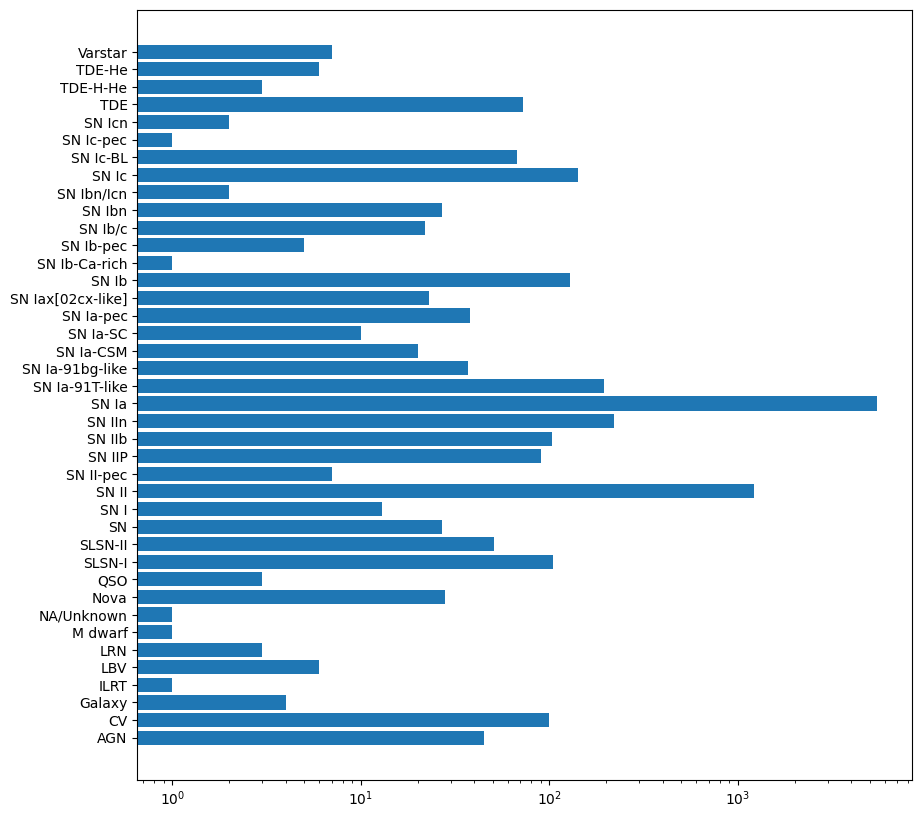

In [13]:
fig = plt.figure(figsize=(10,10))

unique_types, counts = np.unique(types, return_counts=True)

plt.barh(unique_types, counts)
plt.xscale('log')

In [14]:
acceptable_types = ['SN Ia', 'SN Ib/c', "SN Ic-BL", "SN Ic", "SN Ib"]
ibc_types = ['SN Ib/c', "SN Ic-BL", "SN Ic", "SN Ib"]

acceptable_indexes = [i for i in range(len(types)) if types[i] in acceptable_types]
[counts[i] for i in [list(unique_types).index(t) for t in acceptable_types]]

[5467, 22, 67, 142, 129]

In [15]:
indexes_to_use = np.concatenate((np.random.choice([i for i in range(len(types)) if types[i] == 'SN Ia'], 360), [i for i in range(len(types)) if types[i] in ibc_types]))
len(indexes_to_use)

720

In [18]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [19]:
sn_objects = []
for i in indexes_to_use:
    try:
        ia_result, ia_fitted_model = fit_ia(redshifts[i], [lcs[i]])
        ibc_result, ibc_fitted_model = fit_ibc(redshifts[i], [lcs[i]])
        sn_obj = real_SN(types[i], redshifts[i])
        sn_obj.fit_as_ia(sncosmo.flatten_result(ia_result))
        sn_obj.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        sn_objects.append(sn_obj)
    except Exception as e:
        print(f"Exception for index {i}: {e}")
    


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Exception for index 782: `y` must contain only finite values.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:377: RuntimeWarning: overflow encountered in add
  res = np.cumsum(d * (y[slice1] + y[slice2]) / 2.0, axis=axis)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Exception for index 5942: `y` must contain only finite values.
Trying again...
Exception for index 3751: `y` must contain only finite values.
Trying again...
Exception for index 1630: `y` must contain only finite values.


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
Exception for index 8294: result is NaN for [ 0 0 5 0.5 0.1 20000 ]
Trying again...
Trying again...
Exception for index 3922: `y` must contain only finite values.
Trying again...
Exception for index 4180: `y` must contain only finite values.
Trying again...
Exception for index 751: `y` must contain only finite values.
Trying again...
Exception for index 1387: `y` must contain only finite values.
Trying again...
Exception for index 2972: `y` must contain only finite values.
Trying again...
Trying again...
Exception for index 4053: `y` must contain only finite values.
Trying again...
Exception for index 5074: `y` must contain only finite values.
Trying again...
Trying again...
Exception for index 6056: `y` must contain only finite values.
Trying again...
Exception for index 7773: result is NaN for [ 0 0 0.00348179 0.120635 0.0262287 3367.05 ]
Trying again...
Exception for index 6497: `y` must contain only finite values.
Trying again...
Trying again...
Exception for index 

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in add
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Exception for index 3086: `y` must contain only finite values.
Trying again...
Exception for index 6562: `y` must contain only finite values.
Trying again...
Exception for index 6360: `y` must contain only finite values.
Trying again...
Trying again...
Trying again...
Trying again...
Exception for index 1745: `y` must contain only finite values.
Trying again...
Trying again...
Exception for index 2805: `y` must contain only finite values.
Trying again...
Trying again...
Trying again...
Trying again...
Exception for index 4308: `y` must contain only finite values.
Trying again...
Trying again...
Exception for index 710: `y` must contain only finite values.
Trying again...
Exception for index 2403: `y` must contain only finite values.
Trying again...
Exception for index 370: `y` must contain only finite values.
Trying again...
Exception for index 5317: `y` must contain only finite values.
Trying again...
Exception for index 3191: `y` must contain only finite values.
Trying again...
Tryin

In [20]:
len(sn_objects)

434

In [21]:
sn_objects[1].ia_fit, sn_objects[1].ibc_fit, sn_objects[1].true_redshift, sn_objects[1].true_class

({'t0': 40.7126962208054,
  'x0': 4.448556156144776e-06,
  'x1': -0.1454204959116667,
  'c': -0.025082705191678056},
 {'texp': 25.840354852712903,
  'mej': 0.11202322834419642,
  'fni': 0.05260587202989641,
  'vej': 2000.0000002899728},
 0.05304,
 'SN Ia')

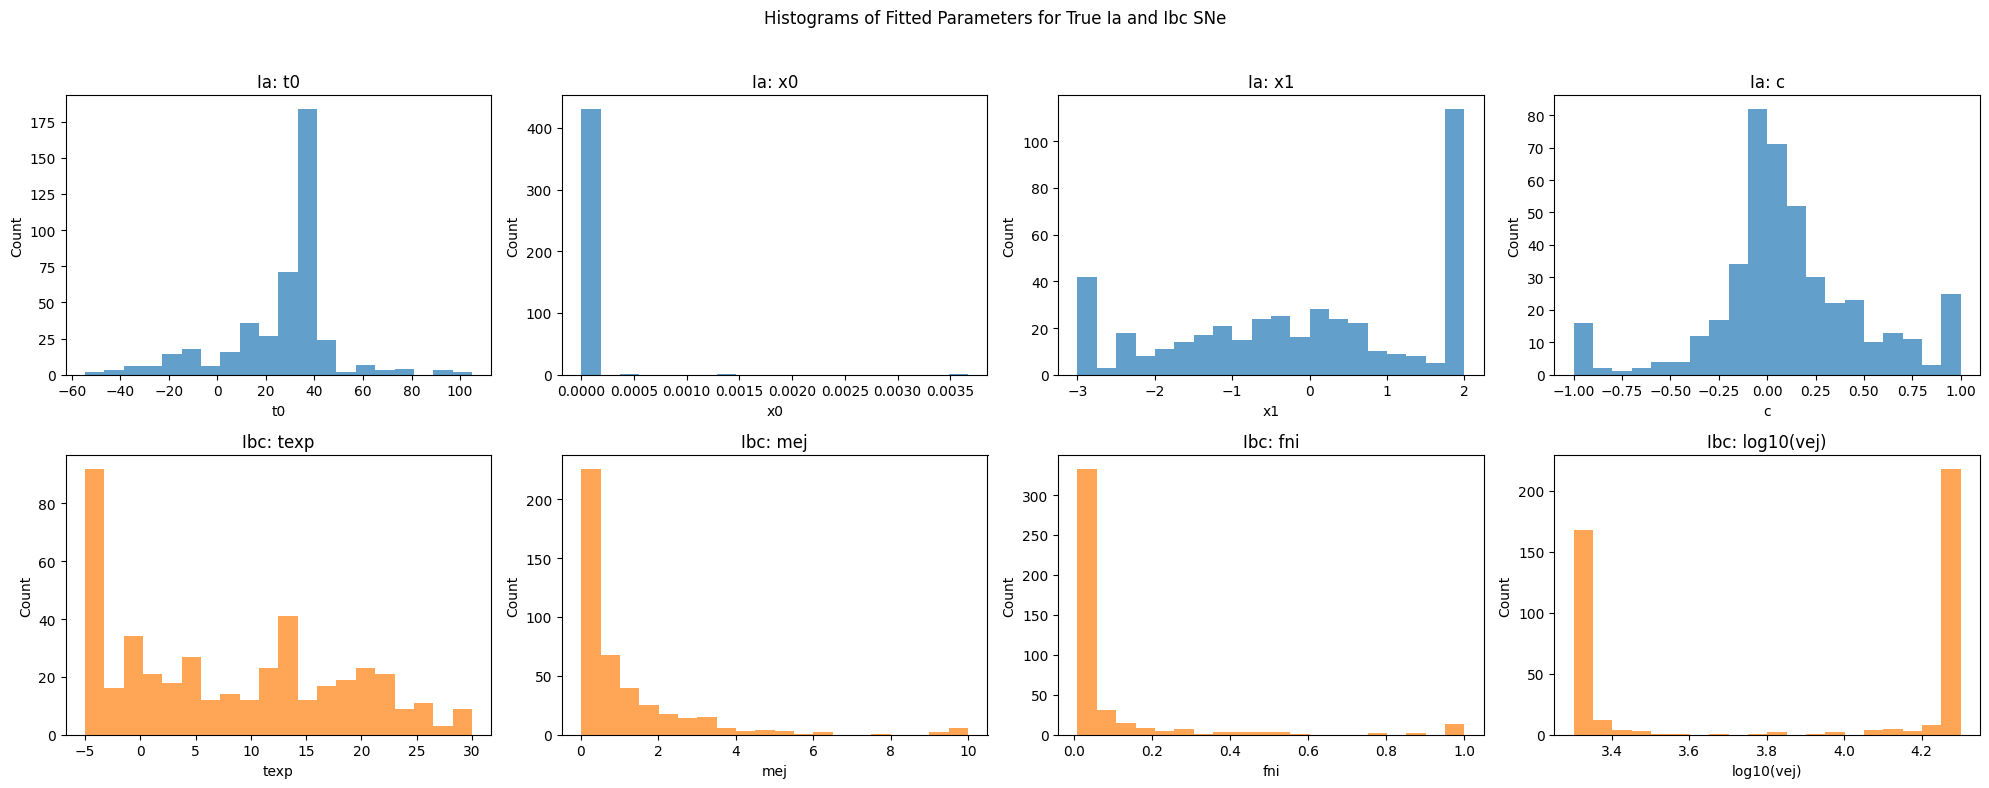

In [22]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

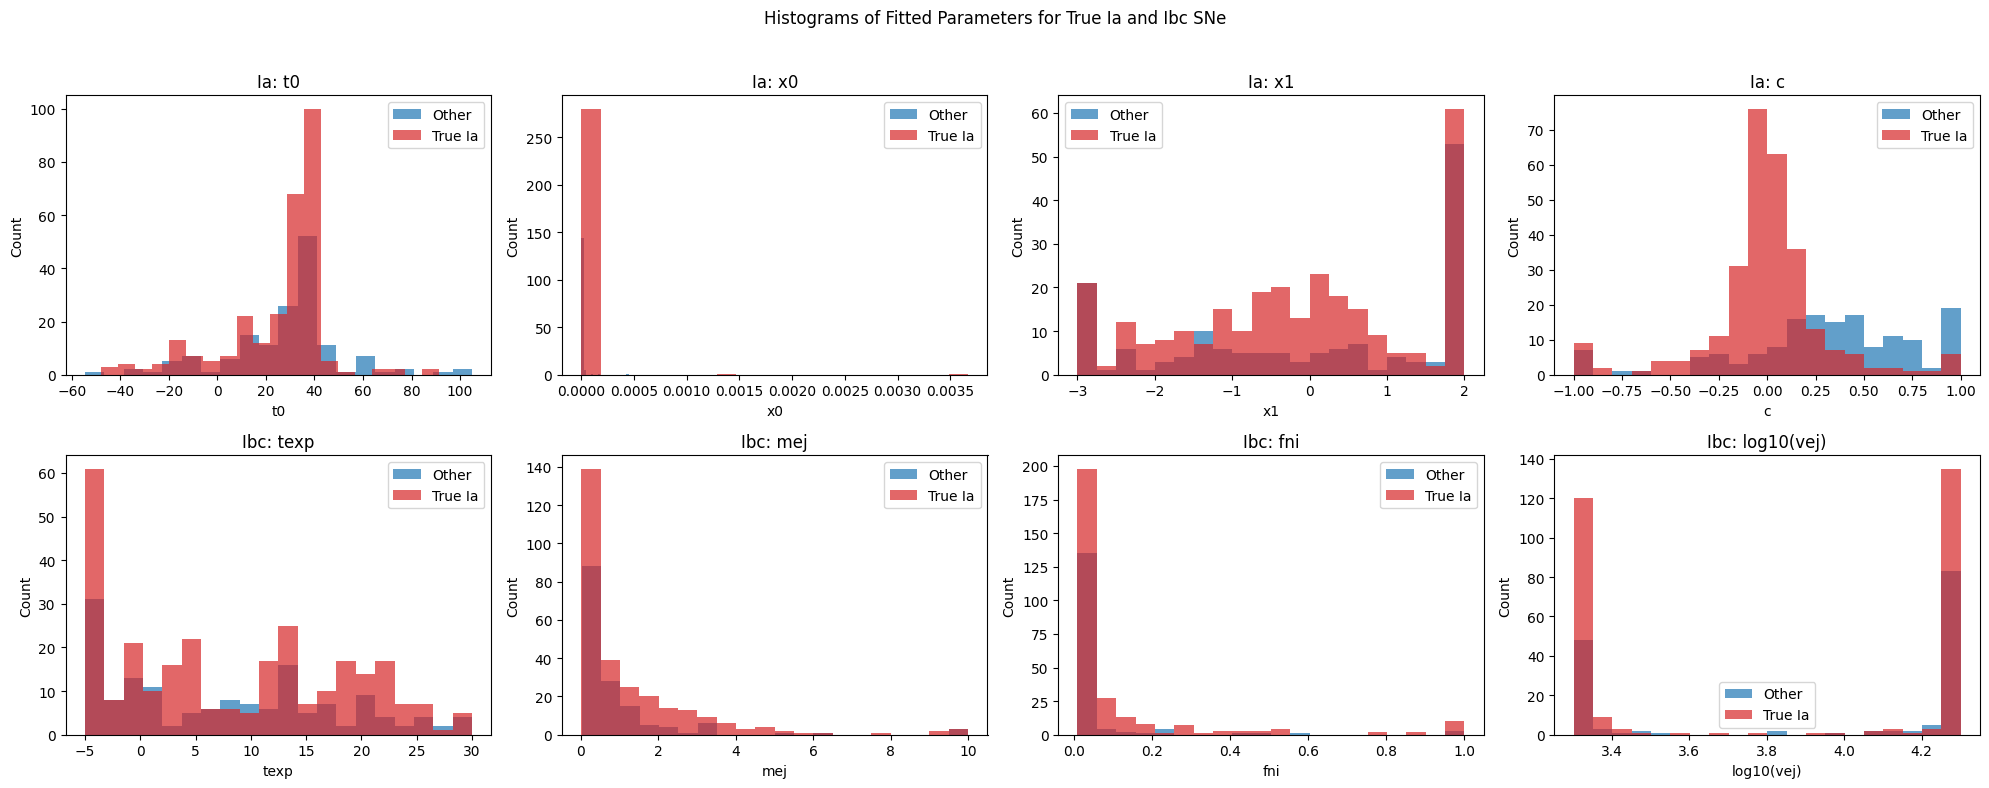

In [23]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values_ia = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class != 'SN Ia']
    axes[0, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
    axes[0, i].hist(values_ia, bins=20, color='tab:red', alpha=0.7, label='True Ia')
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values_ibc = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class != 'SN Ia']
    if param == 'vej':
        values_other = [np.log10(v) for v in values_other if v > 0]
        values_ibc = [np.log10(v) for v in values_ibc if v > 0]
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia')
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other')
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia')
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [24]:
sum([sn.true_class == 'SN Ia' for sn in sn_objects])

282

In [25]:
np.unique([sn.true_class for sn in sn_objects])

array(['SN Ia', 'SN Ib', 'SN Ib/c', 'SN Ic', 'SN Ic-BL'], dtype='<U8')

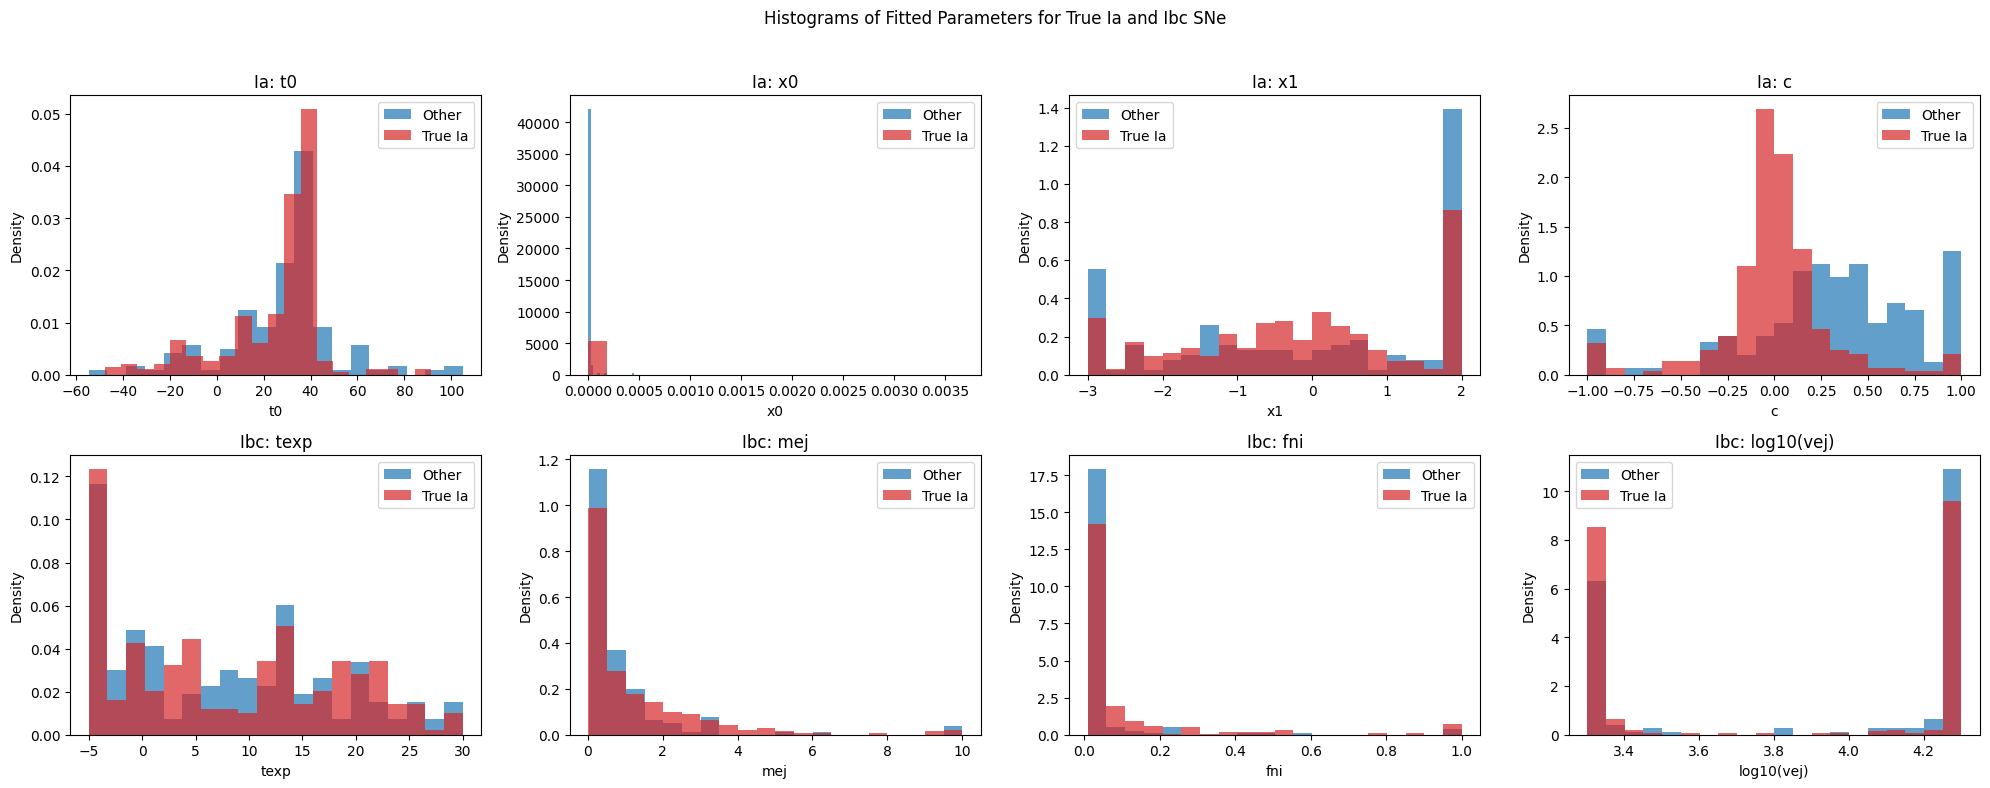

In [27]:
ia_param_names = sn_objects[1].ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = sn_objects[1].ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names):
    values_ia = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ia_fit[param] for sn in sn_objects if sn.ia_fit[param] is not None and sn.true_class != 'SN Ia']
    axes[0, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other', density=True)
    axes[0, i].hist(values_ia, bins=20, color='tab:red', alpha=0.7, label='True Ia', density=True)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Density")
    axes[0, i].legend()

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values_ibc = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class == 'SN Ia']
    values_other = [sn.ibc_fit[param] for sn in sn_objects if sn.ibc_fit[param] is not None and sn.true_class != 'SN Ia']
    if param == 'vej':
        values_other = [np.log10(v) for v in values_other if v > 0]
        values_ibc = [np.log10(v) for v in values_ibc if v > 0]
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other', density=True)
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia', density=True)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values_other, bins=20, color='tab:blue', alpha=0.7, label='Other', density=True)
        axes[1, i].hist(values_ibc, bins=20, color='tab:red', alpha=0.7, label='True Ia', density=True)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Density")
    axes[1, i].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [30]:
np.savez("fitted_sne_real_102925.npz", ia=[sn for sn in sn_objects if sn.true_class == 'SN Ia'], ibc=[sn for sn in sn_objects if sn.true_class != 'SN Ia'])